In [1]:
import os.path, sys

import numpy as np
import pandas as pd
from scipy import linalg
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder
from scipy.spatial import distance

from joblib import Parallel, delayed
from pathlib import Path
import timeit

import matplotlib.pyplot as plt

print('Done with initial import')


create_new = False
printing = True
removing_cols = True
remove_diagonals = False

pdb_path = "/pdb/pdb/"
data_path = Path('/data/cresswellclayec/DCA_ER/Pfam-A.full')
data_path = Path('/data/cresswellclayec/Pfam-A.full')

# Define data directories
DCA_ER_dir = '/data/cresswellclayec/DCA_ER' # Set DCA_ER directory
biowulf_dir = '%s/biowulf_full' % DCA_ER_dir


out_dir = '%s/protein_data/di/' % biowulf_dir
out_metric_dir = '%s/protein_data/metrics/' % biowulf_dir

processed_data_dir = "%s/protein_data/data_processing_output/" % biowulf_dir
pdb_dir = '%s/protein_data/pdb_data/' % biowulf_dir

pdb_id = "3bcc"
pdb_id = "3aac"
prody_df = pd.read_csv('%s/%s_pdb_df.csv' % (pdb_dir, pdb_id))


pdb2msa_row = prody_df.iloc[0]
pfam_id = pdb2msa_row['Pfam']




Done with initial import


In [2]:

if removing_cols:
    s0 = np.load("%s/%s_%s_preproc_msa.npy" % (processed_data_dir, pfam_id, pdb_id))
    s_index = np.load("%s/%s_%s_preproc_sindex.npy" % (processed_data_dir, pfam_id, pdb_id))
    #pdb_s_index = np.load("%s/%s_%s_preproc_pdb_sindex.npy" % (processed_data_dir, pfam_id, pdb_id))
    removed_cols = np.load("%s/%s_%s_removed_cols.npy" % (processed_data_dir, pfam_id, pdb_id))
    ref_seq = np.load("%s/%s_%s_preproc_refseq.npy" % (processed_data_dir, pfam_id, pdb_id))
else:
    s0 = np.load("%s/%s_%s_allCols_msa.npy" % (processed_data_dir, pfam_id, pdb_id))
    s_index = np.load("%s/%s_%s_allCols_sindex.npy" % (processed_data_dir, pfam_id, pdb_id))
    #pdb_s_index = np.load("%s/%s_%s_allCols_pdb_sindex.npy" % (processed_data_dir, pfam_id, pdb_id)) 
    removed_cols = np.load("%s/%s_%s_removed_cols.npy" % (processed_data_dir, pfam_id, pdb_id))
    ref_seq = np.load("%s/%s_%s_allCols_refseq.npy" % (processed_data_dir, pfam_id, pdb_id))
pdb_s_index = s_index # will need to rerun simulations with corrected data_processing (corrected on 3/15/22) to get pdb_s_index. not actually needed in contact mapping......

pfam_dimensions_file = "%s%s_%s_pfam_dimensions.npy" % (processed_data_dir, pdb_id, pfam_id)
pfam_dimensions = np.load(pfam_dimensions_file)
print(pdb_id)
[n_col, n_seq, m_eff, ct_ER, ct_MF, ct_PMF, ct_PLM] = pfam_dimensions
print('Number of Columns: ', n_col)
print('Number of sequences: ', n_seq)
print('Number of effective sequences: ', m_eff)
print('ER, MF, PMF, PLM optimal distance: ', ct_ER, ct_MF, ct_PMF, ct_PLM)

ct_file = "%s%s_%s_ct.npy" % (pdb_dir, pdb_id, pfam_id)
ct = np.load(ct_file)


# load DI data
ER_di = np.load("%s/%s_%s_ER_di.npy" % (out_dir, pdb_id, pfam_id))
MF_di = np.load("%s/%s_%s_MF_di.npy" % (out_dir, pdb_id, pfam_id))
PMF_di_data = np.load("%s/%s_%s_PMF_di.npy" % (out_dir, pdb_id, pfam_id),allow_pickle=True)
PLM_di_data = np.load("%s/%s_%s_PLM_di.npy" % (out_dir, pdb_id, pfam_id),allow_pickle=True)


# transform pydca DI dictionary to DI matrices.
PLM_di = np.zeros(ER_di.shape)
PLM_di_dict = {}
for score_set in PLM_di_data:
    PLM_di_dict[(score_set[0][0], score_set[0][1])] = score_set[1]
for i, index_i in enumerate(s_index):
    for j, index_j in enumerate(s_index):
        if i==j:
            PLM_di[i,j] = 1.
            continue
        try:
            PLM_di[i,j] = PLM_di_dict[(index_i, index_j)]
            PLM_di[j,i] = PLM_di_dict[(index_i, index_j)] # symetric
        except(KeyError):
            continue

PMF_di = np.zeros(ER_di.shape)
PMF_di_dict = {}
for score_set in PMF_di_data:
    PMF_di_dict[(score_set[0][0], score_set[0][1])] = score_set[1]
for i, index_i in enumerate(s_index):
    for j, index_j in enumerate(s_index):
        if i==j:
            PMF_di[i,j] = 1.
            continue
        try:
            PMF_di[i,j] = PMF_di_dict[(index_i, index_j)]
            PMF_di[j,i] = PMF_di_dict[(index_i, index_j)] # symetric
        except(KeyError):
            continue


3aac
Number of Columns:  70.0
Number of sequences:  19175.0
Number of effective sequences:  10599.86981828027
ER, MF, PMF, PLM optimal distance:  4.0 5.0588235294117645 4.352941176470588 4.0


# ER

In [3]:
file_end = "_ld5.npy"
file_end = ".npy"
fp_file = "%s%s_%s_ER_fp%s" % (out_metric_dir, pdb_id, pfam_id, file_end)
tp_file = "%s%s_%s_ER_tp%s" % (out_metric_dir, pdb_id, pfam_id, file_end)
er_fp = np.load(fp_file)
er_tp = np.load(tp_file)

fp_uni_file = "%s%s_%s_ER_fp_uni%s" % (out_metric_dir, pdb_id, pfam_id, file_end)
tp_uni_file = "%s%s_%s_ER_tp_uni%s" % (out_metric_dir, pdb_id, pfam_id, file_end)
er_fp_uni = np.load(fp_uni_file)
er_tp_uni = np.load(tp_uni_file)


ct1 = ct.copy()
ct_pos = ct < 6
ct1[ct_pos] = 1
ct1[~ct_pos] = 0
mask = np.triu(np.ones(ER_di.shape[0], dtype=bool), k=1)
# argsort sorts from low to high. [::-1] reverses 
order = ER_di[mask].argsort()[::-1]

ld_thresh = 0.
linear_distance = np.zeros((len(s_index),len(s_index)))                                                                                                   
for i, ii in enumerate(s_index):                                                                                                                          
    for j, jj in enumerate(s_index):                                                                                                                      
        linear_distance[i,j] = abs(ii - jj)   


ld = linear_distance >= ld_thresh                                                                                                                         
ld_flat = ld[mask][order]          

ER_di_flat = ER_di[mask][order]
ct_flat = ct1[mask][order]
dist_flat = ct[mask][order]



# PLM

In [4]:
fp_file = "%s%s_%s_PLM_fp%s" % (out_metric_dir, pdb_id, pfam_id, file_end)
tp_file = "%s%s_%s_PLM_tp%s" % (out_metric_dir, pdb_id, pfam_id, file_end)
plm_fp = np.load(fp_file)
plm_tp = np.load(tp_file)

fp_uni_file = "%s%s_%s_PLM_fp_uni%s" % (out_metric_dir, pdb_id, pfam_id, file_end)
tp_uni_file = "%s%s_%s_PLM_tp_uni%s" % (out_metric_dir, pdb_id, pfam_id, file_end)
plm_fp_uni = np.load(fp_uni_file)
plm_tp_uni = np.load(tp_uni_file)

ct_pos_file = "%s%s_%s_PLM_ct_flat%s" % (processed_data_dir, pdb_id, pfam_id, file_end)
plm_ct_flat = np.load(ct_pos_file)

PLM_di_flat = PLM_di[mask][order] # get array of plm di in the order of ER di to plot together



# Plot DI method comparison (plot functions) 

In [5]:
def plot_di_vs_ct(ax, ct_flat, dist_flat, dis_flat, ld_flat, labels):
    colors = 'brg'
    for ii, di_flat in enumerate(dis_flat):
        fmethod = True
        for i, contact in enumerate(ct_flat):
            if fmethod:
                ax.scatter(dist_flat[i], di_flat[i], marker='.',  c=colors[ii], label=labels[ii])
                fmethod=False
            else:
                ax.scatter(dist_flat[i], di_flat[i], marker='.',  c=colors[ii])

    ax.set_xlabel('Distance ($\AA$)')
    ax.set_ylabel('DI')
    return ax

In [6]:
def plot_di_compare_methods(ax, ct_flat, di1_flat, di2_flat, ld_flat, labels):
    ec = 'b'
    f1 = True
    f2 = True
    f3 = True
    for j in range(len(ct_flat), -1, -1):
        i = j-1
        contact = ct_flat[i]
        if not ld_flat[i]:
            if f1:
                ax.scatter(di1_flat[i], di2_flat[i], marker='x',  c='k', alpha=.2, label='to close')
                f1 = False
            else:
                ax.scatter(di1_flat[i], di2_flat[i],  marker='x',  c='k', alpha=.2)
    
        elif contact==1.:
            if f2:
                ax.scatter(di1_flat[i], di2_flat[i], marker='o', facecolors='none', edgecolors='g', label='contact')
                f2=False
            else:
                ax.scatter(di1_flat[i], di2_flat[i],  marker='o', facecolors='none', edgecolors='g')
        else:
            if f3:
                ax.scatter(di1_flat[i], di2_flat[i], marker='_', c='r', label='no contact')
                f3 = False
            else:
                ax.scatter(di1_flat[i], di2_flat[i], marker='_', c='r')
    ax.set_xlabel('%s DI' % labels[0])
    ax.set_ylabel('%s DI' % labels[1])
    return ax


In [7]:
def plot_contact_map(ax, ct, DI, s_index, ld_flat, labels):
    ec = 'b'
    f1 = True
    f2 = True
    f3 = True
    for j, contact in enumerate(ct_flat):
        if not ld_flat[i]:
            if f1:
                ax.scatter(di1_flat[i], di2_flat[i], marker='x',  c='k', alpha=.2, label='to close')
                f1 = False
            else:
                ax.scatter(di1_flat[i], di2_flat[i],  marker='x',  c='k', alpha=.2)
    
        elif contact==1.:
            if f2:
                ax.scatter(di1_flat[i], di2_flat[i], marker='o', facecolors='none', edgecolors='g', label='contact')
                f2=False
            else:
                ax.scatter(di1_flat[i], di2_flat[i],  marker='o', facecolors='none', edgecolors='g')
        else:
            if f3:
                ax.scatter(di1_flat[i], di2_flat[i], marker='_', c='r', label='no contact')
                f3 = False
            else:
                ax.scatter(di1_flat[i], di2_flat[i], marker='_', c='r')
    ax.set_xlabel('%s DI' % labels[0])
    ax.set_ylabel('%s DI' % labels[1])
    return ax


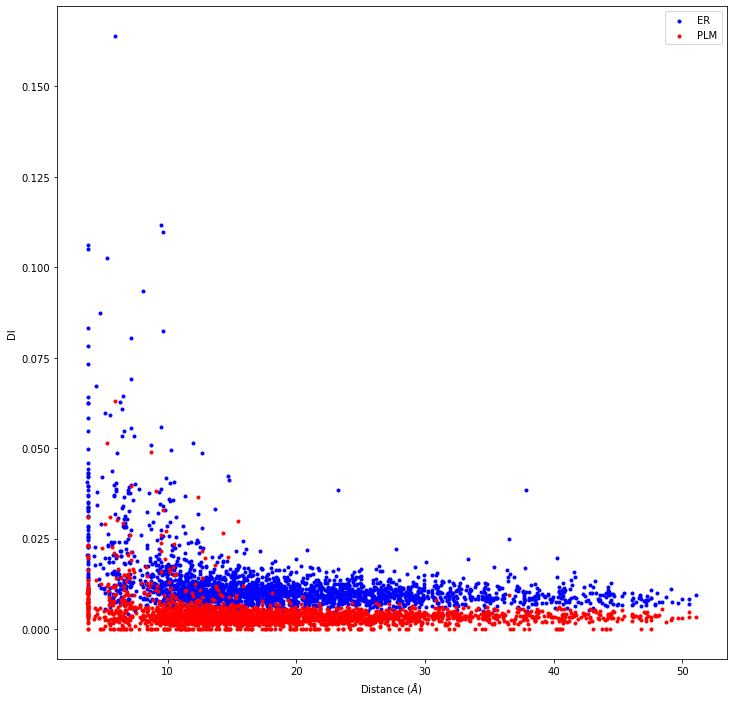

In [8]:
labels = ['ER', 'PLM']
flat_dis =  [ER_di_flat, PLM_di_flat]

plt.figure(figsize=(12,12))
ax = plt.subplot2grid((1,1),(0,0))
ax = plot_di_vs_ct(ax, ct_flat, dist_flat, flat_dis, ld_flat, labels)
ax.legend()
plt.show()



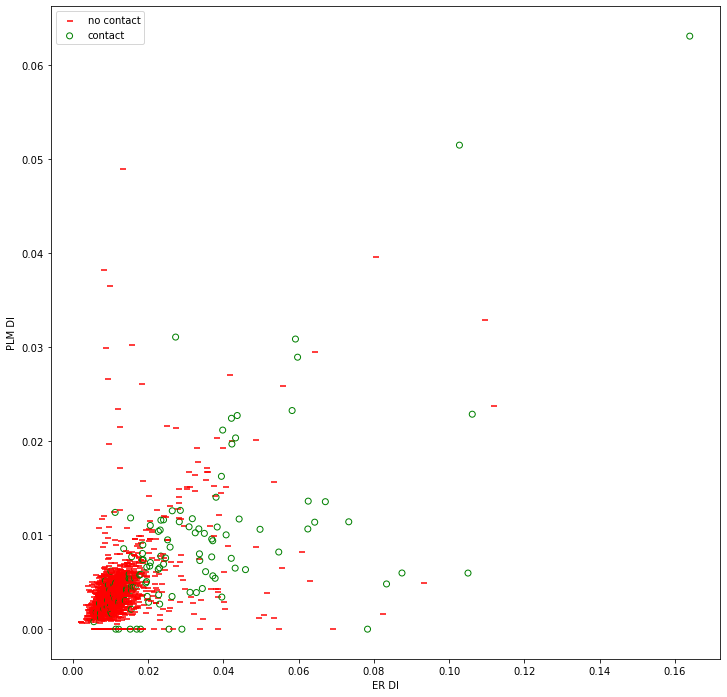

In [9]:
plt.figure(figsize=(12,12))
ax = plt.subplot2grid((1,1),(0,0))
ax = plot_di_compare_methods(ax, ct_flat, flat_dis[0], flat_dis[1], ld_flat, labels)
ax.legend()
plt.show()

